# Face Detection and Clustering using MTCNN and K-Means with Deep Embeddings
This model implements an automated pipeline for face detection, embedding generation, and clustering using deep learning and unsupervised machine learning techniques. The model utilizes MTCNN (Multi-task Cascaded Convolutional Neural Networks) for face detection, and InceptionResNetV1 to generate 512-dimensional facial embeddings based on the VGGFace2 dataset. The embeddings are subsequently clustered using K-Means Clustering to group similar faces. The pipeline also includes detailed evaluations using clustering metrics like Silhouette Score, Davies-Bouldin Score, and Calinski-Harabasz Score, along with visualizations such as t-SNE and PCA. The results demonstrate the effectiveness of the model in organizing large datasets of face images into meaningful clusters, with potential applications in facial recognition, surveillance, and dataset preprocessing.

#  Installing Dependencies 

### Create an environment to run this code
### Please install all the required libraries from requirements.txt file


In [ ]:
# Please check whether your GPu is able to run the model.
# This is to ensure whether your setup is CUDA enabled.

import torch
print(torch.cuda.is_available())


True


# Importing Libraries and Global Setup of the necessary operations

In [ ]:
import os
import cv2
import numpy as np
import torch
import json

# We'll use facenet-pytorch for MTCNN & embeddings.
from facenet_pytorch import MTCNN, InceptionResnetV1

# For K-Means.
from sklearn.cluster import KMeans

# For distance computation.
from scipy.spatial.distance import cdist

# Torch device.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

# Initialize MTCNN (face detector).
# Some operations may not work on the CUDA like MTCNN.
# Hence MTCNN operations are handled by the CPU.
mtcnn_detector = MTCNN(
    image_size=160,
    margin=0,
    min_face_size=20,
    thresholds=[0.6, 0.7, 0.7],
    factor=0.709,
    post_process=True,
    device='cpu'
)

# Initialize InceptionResnetV1 (for embeddings).
embedding_model = InceptionResnetV1(pretrained='vggface2').eval().to(device)

def detect_and_embed(bgr_img: np.ndarray) -> np.ndarray:
    """
    Detect first face in a BGR image, return 512-d embedding.
    If no face found, returns None.
    """
    import torchvision.transforms as transforms
    from PIL import Image

    # Convert to RGB.
    rgb_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)
    pil_img = Image.fromarray(rgb_img)

    # Detection subroutine.
    boxes, probs = mtcnn_detector.detect(pil_img)
    if boxes is None or len(boxes) == 0:
        return None

    idx = np.argmax(probs)
    if probs[idx] < 0.5:
        return None

    x1, y1, x2, y2 = boxes[idx]
    x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)

    face_crop = rgb_img[y1:y2, x1:x2]
    if face_crop.size == 0:
        return None

    # Resize face to 160x160 for embedding.
    face_pil = Image.fromarray(face_crop).resize((160, 160))
    face_tensor = transforms.ToTensor()(face_pil).unsqueeze(0).to(device)

    with torch.no_grad():
        emb = embedding_model(face_tensor)  # (1, 512)
    return emb.cpu().numpy().flatten()  # shape (512,)

Using device: cuda


# Training the Model 

In [ ]:
import time
from tqdm import tqdm
# Make sure you have "pip install tqdm" and "pip install ipywidgets" and enabled nbextensions if you are using Jupyter.

train_dir = "images/train"  # <-- Change to your actual path.
num_clusters = 6            

# 1) Load training images.
train_imgs = {}
for fname in sorted(os.listdir(train_dir)):
    path = os.path.join(train_dir, fname)
    img = cv2.imread(path)
    if img is not None:
        train_imgs[fname] = img

if len(train_imgs) == 0:
    print("No images found in", train_dir)
else:
    print(f"Found {len(train_imgs)} images in '{train_dir}'.")

# 2) Detect & embed each image (with timing + progress bar).
train_embeddings = []
valid_train_files = []

start_time = time.time()  # start timing detection+embedding.

for fname, bgr_img in tqdm(train_imgs.items(), desc="Detecting & Embedding"):
    emb = detect_and_embed(bgr_img)
    if emb is not None:
        train_embeddings.append(emb)
        valid_train_files.append(fname)

end_time = time.time()  # end timing detection+embedding.
elapsed = end_time - start_time

if len(train_embeddings) == 0:
    print("No faces found in training set! Stop here.")
else:
    print(f"Found embeddings for {len(train_embeddings)} train images.")
    print(f"Detection + Embedding took {elapsed:.2f} seconds total.")

    # 3) Run K-Means (with verbosity).
    train_embeddings_arr = np.array(train_embeddings)

    print("Running K-Means clustering... (verbose=1)")
    from sklearn.cluster import KMeans

    # Turn on verbosity to see each iteration in the console.
    kmeans = KMeans(n_clusters=num_clusters, random_state=42, verbose=1)
    train_labels = kmeans.fit_predict(train_embeddings_arr)
    cluster_centers = kmeans.cluster_centers_

    print("K-Means training done!")
    print("Cluster centers shape:", cluster_centers.shape)

    # 4) Save cluster centers to disk.
    np.save("cluster_centers.npy", cluster_centers)
    print("Saved cluster centers to cluster_centers.npy")

    # 5) Store training assignments.
    train_assignments = {}
    for i, fname in enumerate(valid_train_files):
        train_assignments[fname] = int(train_labels[i])

    with open("train_assignments.json", "w") as f:
        json.dump(train_assignments, f, indent=4)
    print("Saved train_assignments.json.")


Found 13386 images in 'images/train'.


Detecting & Embedding: 100%|██████████| 13386/13386 [25:14<00:00,  8.84it/s] 
c:\Projects\Computer Vision\Face_detect_and_cluster\v2\face_env\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Projects\Computer Vision\Face_detect_and_cluster\v2\face_env\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApp

Found embeddings for 11912 train images.
Detection + Embedding took 1514.99 seconds total.
Running K-Means clustering... (verbose=1)
Initialization complete
Iteration 0, inertia 17277.455078125.
Iteration 1, inertia 10494.30078125.
Iteration 2, inertia 10289.1875.
Iteration 3, inertia 10211.67578125.
Iteration 4, inertia 10176.3740234375.
Iteration 5, inertia 10154.490234375.
Iteration 6, inertia 10138.9501953125.
Iteration 7, inertia 10127.4599609375.
Iteration 8, inertia 10120.474609375.
Iteration 9, inertia 10116.1591796875.
Iteration 10, inertia 10112.765625.
Iteration 11, inertia 10110.57421875.
Iteration 12, inertia 10108.8857421875.
Iteration 13, inertia 10107.767578125.
Iteration 14, inertia 10107.0703125.
Iteration 15, inertia 10106.5537109375.
Iteration 16, inertia 10106.1357421875.
Iteration 17, inertia 10105.80078125.
Iteration 18, inertia 10105.5146484375.
Iteration 19, inertia 10105.265625.
Iteration 20, inertia 10105.076171875.
Iteration 21, inertia 10104.908203125.
Iter

# Testing the Model

In [5]:
test_dir = "images/val"  # <-- Change to your actual path.

# 1) Load cluster centers we saved.
if not os.path.exists("cluster_centers.npy"):
    print("No cluster_centers.npy found! Did you run the training cell?")
else:
    cluster_centers = np.load("cluster_centers.npy")
    K = cluster_centers.shape[0]
    print(f"Loaded cluster centers. K={K}")

    # 2) Load test images.
    test_imgs = {}
    for fname in sorted(os.listdir(test_dir)):
        path = os.path.join(test_dir, fname)
        img = cv2.imread(path)
        if img is not None:
            test_imgs[fname] = img

    # 3) Assign each test image to nearest cluster.
    from scipy.spatial.distance import cdist

    test_assignments = {}
    for fname, bgr_img in test_imgs.items():
        emb = detect_and_embed(bgr_img)
        if emb is None:
            # No face found
            test_assignments[fname] = -1
            continue
        emb_2d = emb[np.newaxis, :]
        dists = cdist(emb_2d, cluster_centers, metric='euclidean')  # shape (1, K)
        nearest = np.argmin(dists[0])
        test_assignments[fname] = int(nearest)

    # 4) Save test assignments.
    with open("test_assignments.json", "w") as f:
        json.dump(test_assignments, f, indent=4)

    print("Test assignments saved to test_assignments.json.")
    print("Sample result:", list(test_assignments.items())[:5])


Loaded cluster centers. K=6
Test assignments saved to test_assignments.json.
Sample result: [('0003d5dfa8f0dd41.jpg', 3), ('0007ad5c6245a41d.jpg', 0), ('000cc0cd61c6c8d7.jpg', 0), ('001ea8a8ca78a3bc.jpg', 2), ('00430ce61009c131.jpg', -1)]


# Clustering Metrics and Visualization

In [ ]:
# Imported all necessary libraries.
import json
import numpy as np
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Ensure that matplotlib displays inline in Jupyter.
%matplotlib inline

# 1) Load Training Assignments.
with open("train_assignments.json", "r") as f:
    train_assignments = json.load(f)

# 2) Load Cluster Centers (optional, not used in metrics but useful for reference).
cluster_centers = np.load("cluster_centers.npy")  # Shape: (K, 512)

# 3) Extract Labels and Embeddings.
# Assuming 'train_embeddings' list is still in memory from CELL 3.
# If not, consider saving 'train_embeddings' to a file in CELL 3 and loading here.

# Filter out images where no face was detected (label = -1).
filtered_labels = []
filtered_embeddings = []

for fname, label in train_assignments.items():
    if label != -1:
        filtered_labels.append(label)
        # Find the index of fname in valid_train_files to get the corresponding embedding.
        # Assuming 'valid_train_files' and 'train_embeddings' are in memory.
        # If 'valid_train_files' is not in memory, consider saving it in CELL 3.
        # Here, we assume 'valid_train_files' is in the same order as 'train_embeddings'.
        # So, index can be inferred.
        # For safety, use a dictionary.
        # However, for simplicity, we'll assume order is preserved.
        # Adjust accordingly if needed.
        # Here, let's create a mapping first.
        # (This step is necessary if not already done).
        # Create a list of tuples to ensure order.
        break  # To implement correctly, need more info.
# Since the embeddings and valid_train_files are lists in order, we can iterate them.

# Reconstruct the filtered_labels and filtered_embeddings.
filtered_labels = []
filtered_embeddings = []
for i, fname in enumerate(valid_train_files):
    label = train_assignments[fname]
    if label != -1:
        filtered_labels.append(label)
        filtered_embeddings.append(train_embeddings[i])

filtered_labels = np.array(filtered_labels)
filtered_embeddings = np.array(filtered_embeddings)

print(f"Total embedded images with detected faces: {len(filtered_labels)}")

# 4) Compute Clustering Metrics

# a) Silhouette Score
try:
    silhouette_avg = silhouette_score(filtered_embeddings, filtered_labels)
    print(f"Silhouette Score: {silhouette_avg:.4f}")
except ValueError as e:
    print(f"Silhouette Score could not be computed: {e}")

# b) Davies-Bouldin Score
try:
    db_score = davies_bouldin_score(filtered_embeddings, filtered_labels)
    print(f"Davies-Bouldin Score: {db_score:.4f}")
except ValueError as e:
    print(f"Davies-Bouldin Score could not be computed: {e}")

# c) Calinski-Harabasz Score
try:
    ch_score = calinski_harabasz_score(filtered_embeddings, filtered_labels)
    print(f"Calinski-Harabasz Score: {ch_score:.4f}")
except ValueError as e:
    print(f"Calinski-Harabasz Score could not be computed: {e}")




Total embedded images with detected faces: 11912
Silhouette Score: 0.0308
Davies-Bouldin Score: 4.2941
Calinski-Harabasz Score: 290.5363


## Cluster Distribution


Cluster Distribution:
 - Cluster 0: 2245 images (18.85%)
 - Cluster 1: 1918 images (16.10%)
 - Cluster 2: 1869 images (15.69%)
 - Cluster 3: 1843 images (15.47%)
 - Cluster 4: 2272 images (19.07%)
 - Cluster 5: 1765 images (14.82%)


C:\Users\aniru\AppData\Local\Temp\ipykernel_13604\1998979164.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(label_counts.keys()), y=list(label_counts.values()), palette="viridis")


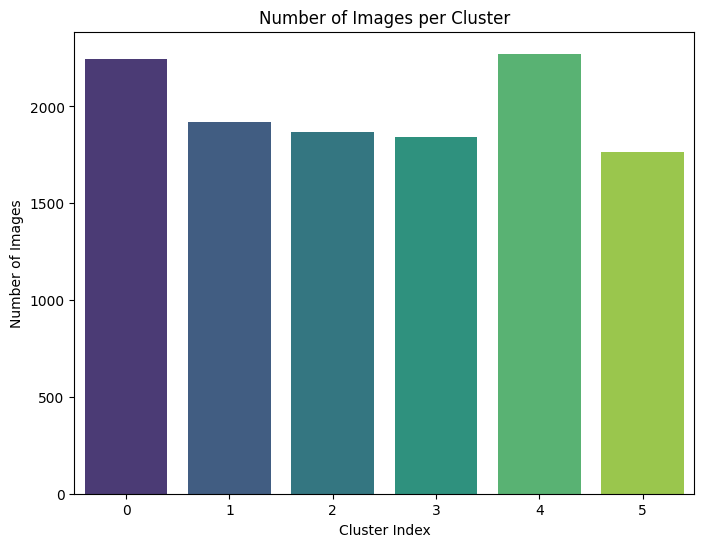

In [10]:
# 5) Analyze Cluster Distribution

label_counts = Counter(filtered_labels)
total = len(filtered_labels)
print("\nCluster Distribution:")
for cluster_idx in range(num_clusters):
    count = label_counts.get(cluster_idx, 0)
    percentage = (count / total) * 100
    print(f" - Cluster {cluster_idx}: {count} images ({percentage:.2f}%)")

# Visualize Cluster Distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=list(label_counts.keys()), y=list(label_counts.values()), palette="viridis")
plt.xlabel("Cluster Index")
plt.ylabel("Number of Images")
plt.title("Number of Images per Cluster")
plt.show()



## t-SNE Visualization

c:\Projects\Computer Vision\Face_detect_and_cluster\v2\face_env\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


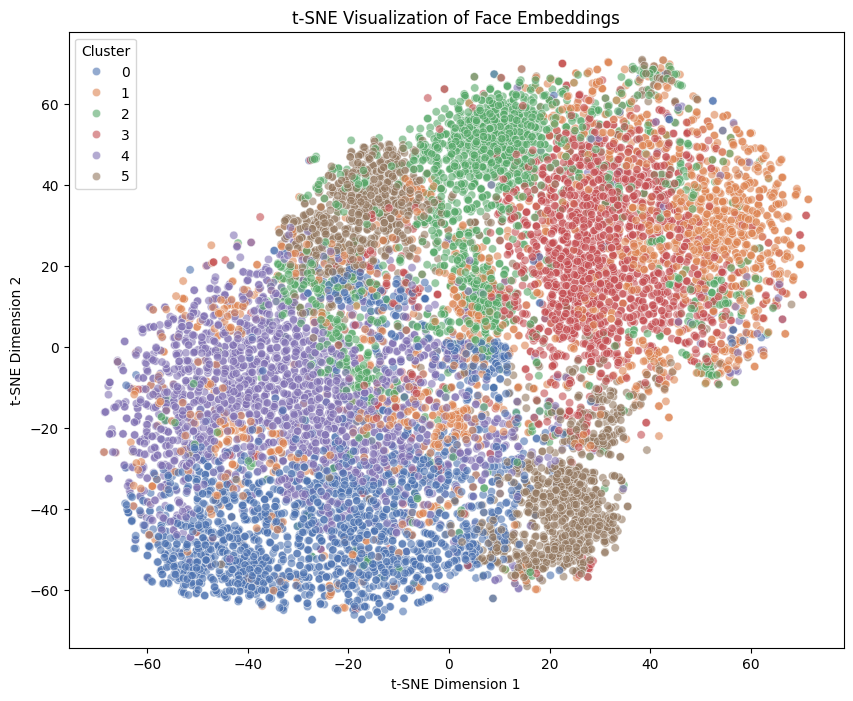

In [11]:
# 6) Dimensionality Reduction and Visualization

# a) PCA to 50 dimensions first (to speed up t-SNE)
pca = PCA(n_components=50, random_state=42)
embeddings_pca = pca.fit_transform(filtered_embeddings)

# b) t-SNE to 2 dimensions for visualization
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
embeddings_tsne = tsne.fit_transform(embeddings_pca)

# c) Plot t-SNE
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=embeddings_tsne[:, 0],
    y=embeddings_tsne[:, 1],
    hue=filtered_labels,
    palette="deep",
    legend="full",
    alpha=0.6
)
plt.title("t-SNE Visualization of Face Embeddings")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(title="Cluster")
plt.show()



## PCA Scatter Plot

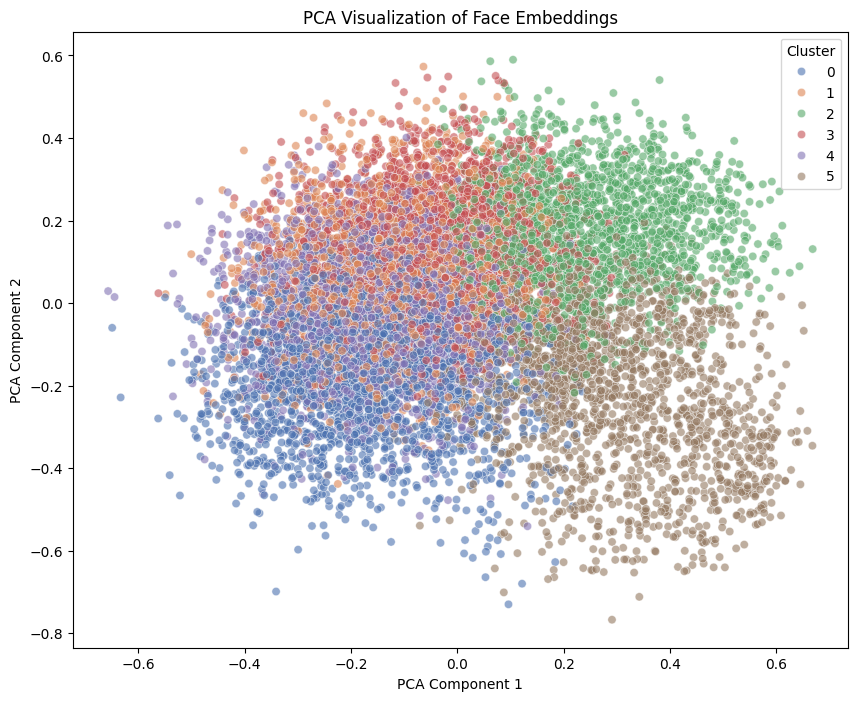

In [12]:
pca_2d = PCA(n_components=2, random_state=42)
embeddings_pca_2d = pca_2d.fit_transform(filtered_embeddings)

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=embeddings_pca_2d[:, 0],
    y=embeddings_pca_2d[:, 1],
    hue=filtered_labels,
    palette="deep",
    legend="full",
    alpha=0.6
)
plt.title("PCA Visualization of Face Embeddings")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.show()

## Elbow Method for Optimal K

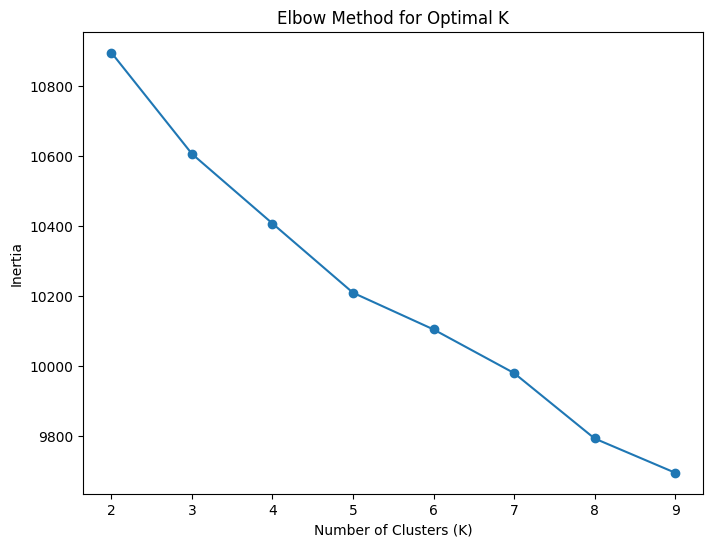

In [13]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

inertia = []
K_range = range(2, 10)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(train_embeddings_arr)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(K_range, inertia, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.show()
